# Home Interval Data Evaluation

## Import 15min LP Energy Usage

In [42]:
import xml.etree.ElementTree as Xet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cols = ["start", "kwh",]
rows = []
  
# Parsing the XML file
namespaces = {'espi': "http://naesb.org/espi", 'ns3': "http://www.w3.org/2005/Atom"}
xmlparse = Xet.parse('EnergyUsage.xml')

root = xmlparse.findall('.//espi:IntervalReading', namespaces)

for i in root:
    if (start := i.find("espi:timePeriod/espi:start", namespaces)) is not None:
        start = start.text
    if (kwh := i.find("espi:value", namespaces)) is not None:
        kwh = float(str(kwh.text))
    #print("start %s, value %s" % (start, kwh))
  
    rows.append({"start": start,
                 "kwh": kwh,})
  
df = pd.DataFrame(rows, columns=cols)
df['time'] = pd.to_datetime(df['start'],unit='s')
df.set_index('time', inplace=True, drop=True)
df.drop(columns=['start'], inplace=True)

### Group by hourly data because our weather data is hourly rather than 15 minute like the energy data

In [43]:
df.tail(96)

,kwh
time,
2022-10-14 00:00:00,0.20
2022-10-14 00:15:00,0.18
2022-10-14 00:30:00,0.27
2022-10-14 00:45:00,0.58
2022-10-14 01:00:00,0.19
...,...
2022-10-14 22:45:00,0.20
2022-10-14 23:00:00,0.23
2022-10-14 23:15:00,0.20


In [44]:
agg_func_math = {
    'kwh':
    ['sum'] }
hourly = df.groupby([df.index.year, df.index.month, df.index.day, df.index.hour], ).agg(agg_func_math)  # type: ignore
hourly.index.names = ['year', 'month', 'day', 'hour']
hourly = hourly.reset_index()

hourly.head()


,year,month,day,hour,kwh
,,,,,sum
0,2020,9,15,0,0.85
1,2020,9,15,1,0.81
2,2020,9,15,2,0.65
3,2020,9,15,3,0.57
4,2020,9,15,4,0.72


### Create a datetime column to index on

#### Raw data is labeled in XML as UTC, but investigation with Duke's website shows that it is actually localtime

In [45]:
import datetime
from pytz import timezone
import pytz
eastern = timezone('US/Eastern') # the energy data is in localtime (even though the input in XML indicates UTC)

def makedate(row):
    return eastern.localize(datetime.datetime(int(row.year), int(row.month), int(row.day), int(row.hour), 0, 0, 0))

hourly['time'] = hourly.apply(lambda row: makedate(row) , axis = 1)

hourly.head()

,year,month,day,hour,kwh,time
,,,,,sum,
0,2020,9,15,0,0.85,2020-09-15 00:00:00-04:00
1,2020,9,15,1,0.81,2020-09-15 01:00:00-04:00
2,2020,9,15,2,0.65,2020-09-15 02:00:00-04:00
3,2020,9,15,3,0.57,2020-09-15 03:00:00-04:00
4,2020,9,15,4,0.72,2020-09-15 04:00:00-04:00


### Get rid of the multindex that was created by the grouping

In [46]:
hourly.columns = hourly.columns.map(''.join)

In [47]:
hourly.head()

,year,month,day,hour,kwhsum,time
0,2020,9,15,0,0.85,2020-09-15 00:00:00-04:00
1,2020,9,15,1,0.81,2020-09-15 01:00:00-04:00
2,2020,9,15,2,0.65,2020-09-15 02:00:00-04:00
3,2020,9,15,3,0.57,2020-09-15 03:00:00-04:00
4,2020,9,15,4,0.72,2020-09-15 04:00:00-04:00


In [48]:
hourly.set_index('time', inplace=True, drop=False)

## Import Weather Data

#### Weather data is using UTC time

In [49]:
wRows = pd.read_csv('weather-data/weather.tsv',delim_whitespace=True , header=0)
wRows.describe()

,WBANNO,UTC_DATE,UTC_TIME,LST_DATE,LST_TIME,CRX_VN,LONGITUDE,LATITUDE,T_CALC,T_HR_AVG,...,SOIL_MOISTURE_5,SOIL_MOISTURE_10,SOIL_MOISTURE_20,SOIL_MOISTURE_50,SOIL_MOISTURE_100,SOIL_TEMP_5,SOIL_TEMP_10,SOIL_TEMP_20,SOIL_TEMP_50,SOIL_TEMP_100
count,24469.0,2.446900e+04,24469.000000,2.446900e+04,24469.000000,24469.000000,24469.00,2.446900e+04,24469.000000,24469.000000,...,24469.000000,24469.000000,24469.000000,24469.000000,24469.000000,24469.000000,24469.000000,24469.000000,24469.000000,24469.000000
mean,3758.0,2.020987e+07,1149.760922,2.020987e+07,1149.887613,2.331319,-79.09,3.597000e+01,-243.393743,-246.262675,...,-2.309985,-2.312699,-2.282937,-2.230146,-2.150810,-241.749720,-241.737840,-241.779958,-241.902730,-241.871123
std,0.0,7.936401e+03,692.180310,7.938625e+03,692.335612,1.814919,0.00,1.421115e-14,1589.845471,1598.376190,...,15.744438,15.756738,15.748763,15.757340,15.859747,1588.815807,1588.817965,1588.809737,1588.786287,1588.788446
min,3758.0,2.020010e+07,0.000000,2.019123e+07,0.000000,-9.000000,-79.09,3.597000e+01,-9999.000000,-9999.000000,...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
25%,3758.0,2.020091e+07,500.000000,2.020091e+07,500.000000,2.622000,-79.09,3.597000e+01,8.300000,8.300000,...,0.207000,0.224000,0.256000,0.313000,0.383000,9.900000,9.900000,10.000000,10.600000,11.700000
50%,3758.0,2.021052e+07,1100.000000,2.021052e+07,1100.000000,2.622000,-79.09,3.597000e+01,16.400000,16.400000,...,0.263000,0.265000,0.283000,0.333000,0.478000,17.000000,17.000000,16.900000,16.600000,16.600000
75%,3758.0,2.022020e+07,1700.000000,2.022020e+07,1800.000000,2.622000,-79.09,3.597000e+01,22.300000,22.300000,...,0.301000,0.292000,0.309000,0.348000,0.491000,23.800000,23.900000,23.800000,22.800000,21.900000
max,3758.0,2.022102e+07,2300.000000,2.022102e+07,2300.000000,2.622000,-79.09,3.597000e+01,35.800000,35.200000,...,0.440000,0.415000,0.432000,0.456000,0.551000,30.700000,31.200000,28.500000,26.500000,25.100000


### Clean bad data

In [50]:
wRows = wRows.drop(['SUR_TEMP_TYPE'],axis=1)

In [51]:
wRows = wRows[wRows.T_HR_AVG >= -100]
wRows = wRows[wRows.T_CALC >= -100]
wRows = wRows[wRows.P_CALC >= -100]
wRows = wRows[wRows.SOIL_MOISTURE_100 >= -50]

wRows.describe()

,WBANNO,UTC_DATE,UTC_TIME,LST_DATE,LST_TIME,CRX_VN,LONGITUDE,LATITUDE,T_CALC,T_HR_AVG,...,SOIL_MOISTURE_5,SOIL_MOISTURE_10,SOIL_MOISTURE_20,SOIL_MOISTURE_50,SOIL_MOISTURE_100,SOIL_TEMP_5,SOIL_TEMP_10,SOIL_TEMP_20,SOIL_TEMP_50,SOIL_TEMP_100
count,23792.0,2.379200e+04,23792.000000,2.379200e+04,23792.000000,23792.000,2.379200e+04,2.379200e+04,23792.000000,23792.000000,...,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000
mean,3758.0,2.020986e+07,1149.142569,2.020985e+07,1149.983188,2.622,-7.909000e+01,3.597000e+01,15.679296,15.675450,...,0.253620,0.254994,0.281378,0.335564,0.446205,16.946423,16.958541,16.915060,16.788984,16.821755
std,0.0,8.033656e+03,692.383445,8.035907e+03,692.830636,0.000,1.421115e-14,1.421115e-14,8.889984,8.879327,...,0.067856,0.057661,0.044899,0.037755,0.059538,7.322584,7.372032,7.062309,6.212369,5.370617
min,3758.0,2.020010e+07,0.000000,2.019123e+07,0.000000,2.622,-7.909000e+01,3.597000e+01,-9.100000,-8.900000,...,0.074000,0.076000,0.143000,0.238000,0.286000,2.000000,2.100000,3.000000,5.200000,7.400000
25%,3758.0,2.020090e+07,500.000000,2.020090e+07,500.000000,2.622,-7.909000e+01,3.597000e+01,9.000000,8.900000,...,0.213000,0.229000,0.258000,0.315000,0.385000,10.400000,10.400000,10.400000,11.100000,12.000000
50%,3758.0,2.021052e+07,1100.000000,2.021052e+07,1150.000000,2.622,-7.909000e+01,3.597000e+01,16.800000,16.800000,...,0.265000,0.266000,0.284000,0.334000,0.479000,17.300000,17.300000,17.200000,16.900000,16.800000
75%,3758.0,2.022021e+07,1700.000000,2.022021e+07,1800.000000,2.622,-7.909000e+01,3.597000e+01,22.400000,22.400000,...,0.301000,0.293000,0.310000,0.349000,0.491000,24.000000,24.000000,23.900000,22.900000,22.100000
max,3758.0,2.022102e+07,2300.000000,2.022102e+07,2300.000000,2.622,-7.909000e+01,3.597000e+01,35.800000,35.200000,...,0.440000,0.415000,0.432000,0.456000,0.551000,30.700000,31.200000,28.500000,26.500000,25.100000


### Create a Datetime row

In [52]:
wRows["DATE"] = pd.to_datetime(wRows["UTC_DATE"],format='%Y%m%d', utc=True)

## Convert time and create a date time

In [53]:
wRows.head(3)

,WBANNO,UTC_DATE,UTC_TIME,LST_DATE,LST_TIME,CRX_VN,LONGITUDE,LATITUDE,T_CALC,T_HR_AVG,...,SOIL_MOISTURE_10,SOIL_MOISTURE_20,SOIL_MOISTURE_50,SOIL_MOISTURE_100,SOIL_TEMP_5,SOIL_TEMP_10,SOIL_TEMP_20,SOIL_TEMP_50,SOIL_TEMP_100,DATE
0,3758,20200101,100,20191231,2000,2.622,-79.09,35.97,7.4,8.0,...,0.241,0.279,0.347,0.400,10.1,11.1,10.8,11.6,12.2,2020-01-01 00:00:00+00:00
1,3758,20200101,200,20191231,2100,2.622,-79.09,35.97,5.9,6.7,...,0.241,0.279,0.346,0.399,9.8,10.9,10.6,11.6,12.2,2020-01-01 00:00:00+00:00
2,3758,20200101,300,20191231,2200,2.622,-79.09,35.97,4.2,5.8,...,0.241,0.278,0.346,0.399,9.5,10.6,10.5,11.5,12.2,2020-01-01 00:00:00+00:00


In [54]:
wRows["UTC_HOUR"] = (wRows["UTC_TIME"]/100).astype(int) # the hour is in some weird 100's value, is this army time?
wRows["UTC_HOUR"] = wRows["UTC_HOUR"].astype(str)
wRows["UTC_HOUR_PAD"] = wRows["UTC_HOUR"].str.zfill(2) # need the hour to be zero padded for the format conversion
wRows["DATE_TIME_STR"] = wRows["UTC_DATE"].astype(str) + wRows["UTC_HOUR_PAD"]
wRows["DATE_TIME"] = pd.to_datetime(wRows["DATE_TIME_STR"], format="%Y%m%d%H", utc=True)
wRows["MONTH"] = wRows["DATE_TIME"].dt.month
wRows["DAY"] = wRows["DATE_TIME"].dt.day
wRows["HOUR"] = wRows["DATE_TIME"].dt.hour

### Create new Dataframe weather with only the columns we want and free memory

In [55]:
weather = wRows.filter(['DATE_TIME', 'T_HR_AVG','SOLARAD', 'P_CALC','RH_HR_AVG'], axis=1)
weather['DEW_POINT'] = weather['T_HR_AVG'] - ((100 - weather['RH_HR_AVG'])/5.0)  # Td = T - ((100 - RH)/5.)
weather.set_index('DATE_TIME', inplace=True)
weather = weather.dropna()
del(wRows, df)

## Join weather data with hourly meter readings join the data on time

In [56]:
readsWeather = hourly.join(weather) # Join weather on meter reads.  
readsWeather.head()

,year,month,day,hour,kwhsum,time,T_HR_AVG,SOLARAD,P_CALC,RH_HR_AVG,DEW_POINT
2020-09-15 04:00:00+00:00,2020,9,15,0,0.85,2020-09-15 00:00:00-04:00,18.9,0.0,0.0,84.0,15.7
2020-09-15 05:00:00+00:00,2020,9,15,1,0.81,2020-09-15 01:00:00-04:00,18.3,0.0,0.0,85.0,15.3
2020-09-15 06:00:00+00:00,2020,9,15,2,0.65,2020-09-15 02:00:00-04:00,17.3,0.0,0.0,86.0,14.5
2020-09-15 07:00:00+00:00,2020,9,15,3,0.57,2020-09-15 03:00:00-04:00,17.1,0.0,0.0,84.0,13.9
2020-09-15 08:00:00+00:00,2020,9,15,4,0.72,2020-09-15 04:00:00-04:00,16.7,0.0,0.0,82.0,13.1


## Data Wrangling

In [57]:
df = readsWeather
df = df.dropna()
df.set_index('time', inplace=True, drop=False)

### Clean the outliers from the energy data

In [17]:
#from scipy import stats
#df = df[(np.abs(stats.zscore(df['kwhsum']))<4)]                                                                                                                                             

## Do some categorization, seasons etc.

In [58]:
def find_season(month, hemisphere):
    if hemisphere == 'Southern':
        season_month_south = {
            12:'Summer', 1:'Summer', 2:'Summer',
            3:'Autumn', 4:'Autumn', 5:'Autumn',
            6:'Winter', 7:'Winter', 8:'Winter',
            9:'Spring', 10:'Spring', 11:'Spring'}
        return season_month_south.get(month)
        
    elif hemisphere == 'Northern':
        season_month_north = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Autumn', 10:'Autumn', 11:'Autumn'}
        return season_month_north.get(month)
    else:
        print('Invalid selection. Please select a hemisphere and try again')

In [59]:
season_list = []
hemisphere = 'Northern'
for month in (df['month']+1): # months in our dataframe are zero based
    season = find_season(month, hemisphere)
    season_list.append(season)
    
df['SEASON'] = season_list

/tmp/ipykernel_22753/3955915769.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SEASON'] = season_list


### Create some bins based on Sunlight and Time Of Day

In [60]:
df['SUNLIGHT'] = pd.cut(x=df['SOLARAD'], bins=[0, 1, 30, 313, 1500],
                     labels=['Dark', 'Mostly Cloudy', 'Sunny',
                             'Full Sun'], include_lowest=True)

df['TIME_OF_DAY'] = pd.cut(x=df['hour'], bins=[0, 8, 12, 18, 23],
                     labels=['Early Morning', 'Late Morning', 'Afternoon',
                             'Evening'], include_lowest=True)

/tmp/ipykernel_22753/3604459303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SUNLIGHT'] = pd.cut(x=df['SOLARAD'], bins=[0, 1, 30, 313, 1500],
/tmp/ipykernel_22753/3604459303.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TIME_OF_DAY'] = pd.cut(x=df['hour'], bins=[0, 8, 12, 18, 23],


In [67]:
import statsmodels.api as sm

#try a very small sample set
#sdf = df.sample(500)
sdf = df

#define response variable
y = sdf['kwhsum']

#define predictor variables
predictor_columns = ['T_HR_AVG', 'DEW_POINT','month', 'hour', 'SOLARAD', ]
x = sdf[predictor_columns]
#add constant to predictor variables
x = sm.add_constant(x)


In [68]:
from sklearn.model_selection import train_test_split 

# Splitting the dataset into 80% training data and 20% testing data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42)

In [69]:
#fit linear regression model
model = sm.OLS(y_train, X_train).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 kwhsum   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     2602.
Date:                Fri, 04 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:15:51   Log-Likelihood:                -19260.
No. Observations:               14072   AIC:                         3.853e+04
Df Residuals:                   14066   BIC:                         3.858e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2061      0.027      7.605      0.0

### Plot OLS regression

eval_env: 1


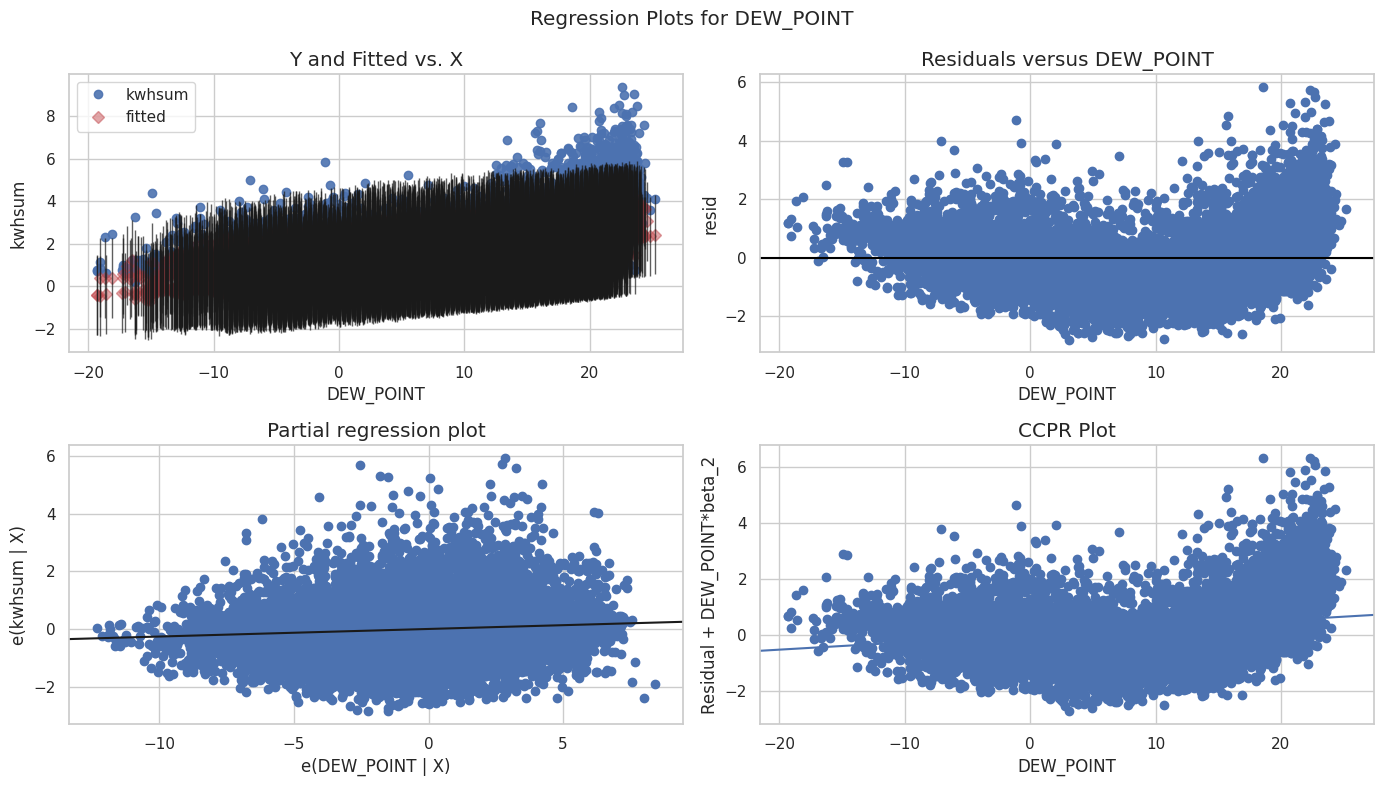

In [70]:
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(model,
                                    'DEW_POINT',
                                    fig=fig)

### Visualize OLS prediction accuracy


RMSE:  0.938


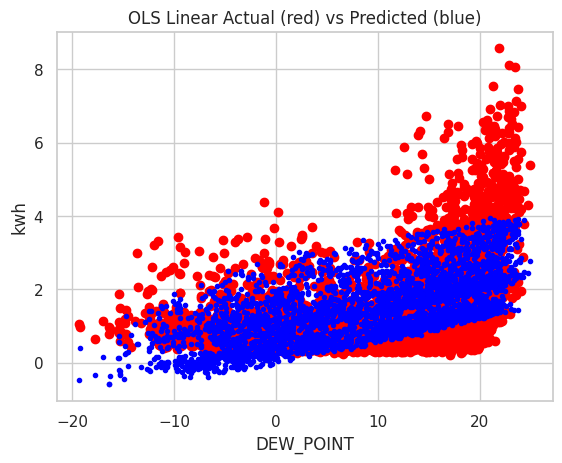

In [71]:
from sklearn.metrics import mean_squared_error # for calculating the cost function

# Predicting the target values of the test set
y_pred = model.predict(X_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)

plt.scatter(X_test['DEW_POINT'], y_test, color = 'red')
plt.scatter(X_test['DEW_POINT'], model.predict(X_test), color = 'blue', marker='.')
plt.title('OLS Linear Actual (red) vs Predicted (blue)')
plt.xlabel('DEW_POINT')
plt.ylabel('kwh')
plt.show()

### Lets try RandomForestRegression

In [80]:
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model

#define response variable
y = df['kwhsum']

#define predictor variables
#use only one feature
predictor_columns = [ 'DEW_POINT','T_HR_AVG', 'month', 'hour', 'SOLARAD', ]
#predictor_columns = ['T_HR_AVG']
x = df[predictor_columns]

# Splitting the dataset into 80% training data and 20% testing data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42)

# Initializing the Random Forest Regression model with 10 decision trees
model = RandomForestRegressor(n_estimators = 10, random_state = 0)

# Fitting the Random Forest Regression model to the data
model.fit(X_train, y_train)

# Predicting the target values of the test set
y_pred = model.predict(X_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  0.643


### Visualize the RandomForestRegression

### Prediction of kwh to Dew Point

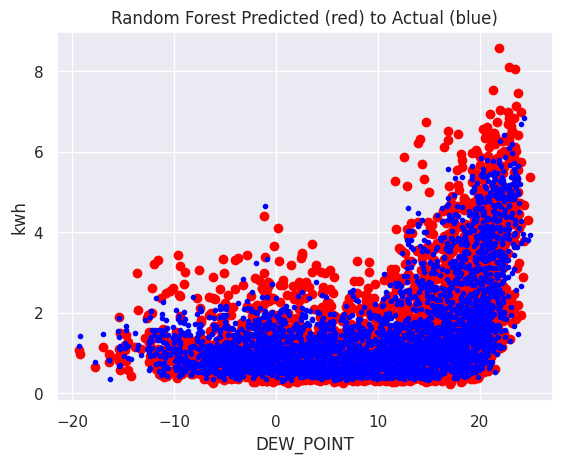

In [78]:
# Visualising the predictive results
plt.scatter(X_test['DEW_POINT'], y_test, color = 'red', marker='o')
plt.scatter(X_test['DEW_POINT'], model.predict(X_test), color = 'blue', marker='.')
plt.title('Random Forest Predicted (red) to Actual (blue)')
plt.xlabel('DEW_POINT')
plt.ylabel('kwh')
plt.show()

### Prediction of kwh to Air Temperature

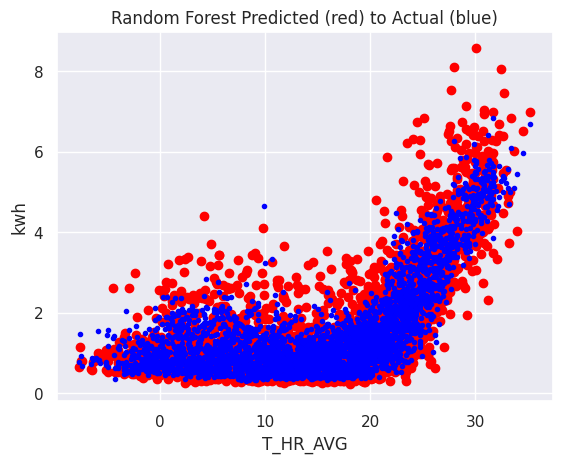

In [76]:
# Visualising the predictive results
plt.scatter(X_test['T_HR_AVG'], y_test, color = 'red', marker='o')
plt.scatter(X_test['T_HR_AVG'], model.predict(X_test), color = 'blue', marker='.')
plt.title('Random Forest Predicted (red) to Actual (blue)')
plt.xlabel('T_HR_AVG')
plt.ylabel('kwh')
plt.show()

## Let's look at the data visually

### Season to Dew Point

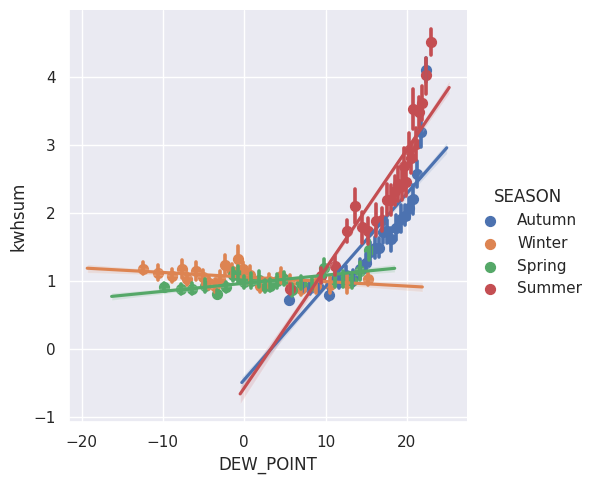

In [74]:
import seaborn as sns
from sklearn.model_selection import train_test_split 

sns.set_theme(style="darkgrid")
#sns.regplot(x='T_HR_AVG', y='kwhsum', data=df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
sns.lmplot(data=df, y='kwhsum', x='DEW_POINT',  x_bins=24, hue="SEASON")
       #palette='Set1',  scatter_kws={"s": 4}, line_kws={"lw":5}, fit_reg=True,)


### Season to Air Temperature

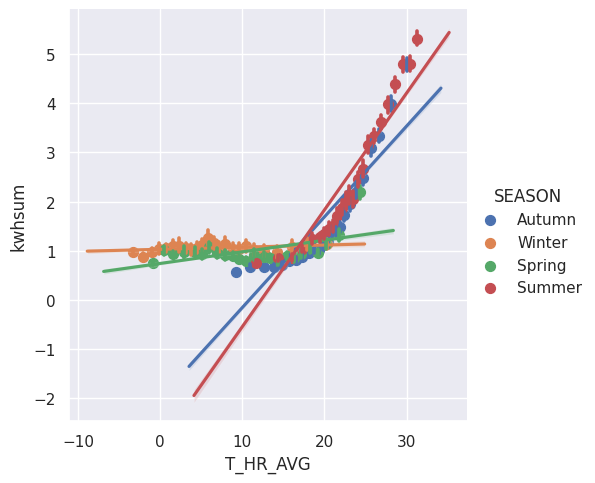

In [75]:
import seaborn as sns
from sklearn.model_selection import train_test_split 

sns.set_theme(style="darkgrid")
#sns.regplot(x='T_HR_AVG', y='kwhsum', data=df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
sns.lmplot(data=df, y='kwhsum', x='T_HR_AVG',  x_bins=24, hue="SEASON")
       #palette='Set1',  scatter_kws={"s": 4}, line_kws={"lw":5}, fit_reg=True,)

##Group energy usage by TIME OF DAY and visualize

/tmp/ipykernel_22753/343757370.py:12: FutureWarning: ['time', 'SEASON', 'SUNLIGHT'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  usage_by_time_of_day = df.groupby("TIME_OF_DAY").agg([np.mean, double_std, sp.sem])


<AxesSubplot: title={'center': 'Average Energy Usage'}, ylabel='TIME_OF_DAY'>

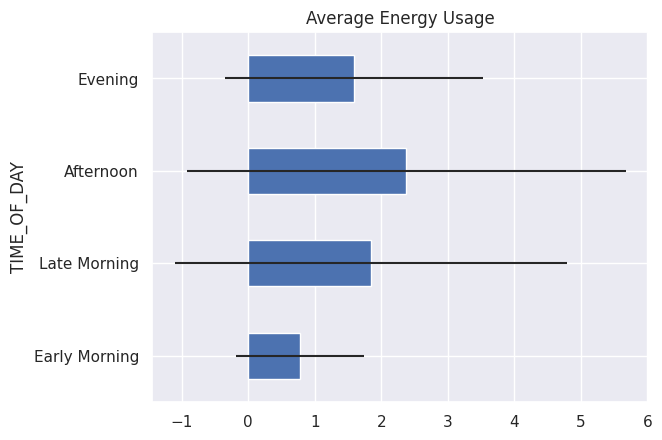

In [29]:
# Imports
import pandas as pd
import numpy as np # for calculating standard deviation and mean
import scipy.stats as sp # for calculating standard error
import matplotlib.pyplot as plt # for improving our visualizations

# function for 2 x STD used in group by aggregation
def double_std(array):
 return np.std(array) * 2

# df.groupby("col_to_group_by").agg([func_1, func_2, func_3])
usage_by_time_of_day = df.groupby("TIME_OF_DAY").agg([np.mean, double_std, sp.sem])
usage_by_time_of_day = usage_by_time_of_day['kwhsum'] #only interested in energy usage

usage_by_time_of_day.plot(kind = "barh", y = "mean", legend = False, title = "Average Energy Usage", xerr = "double_std")


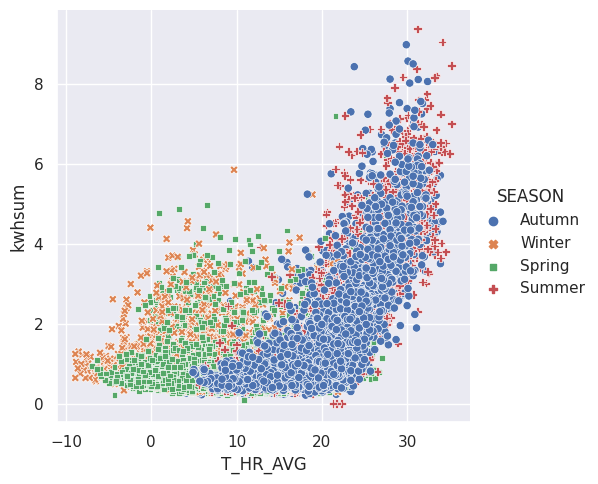

In [30]:
sns.relplot(data=df, x="T_HR_AVG", y="kwhsum", hue="SEASON", style="SEASON")

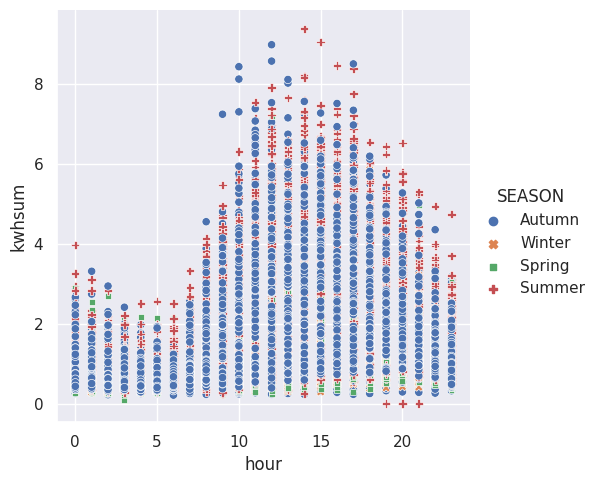

In [31]:
sns.relplot(data=df, x="hour", y="kwhsum", hue="SEASON", style="SEASON")

<AxesSubplot: title={'center': 'kwhsum'}, xlabel='SEASON'>

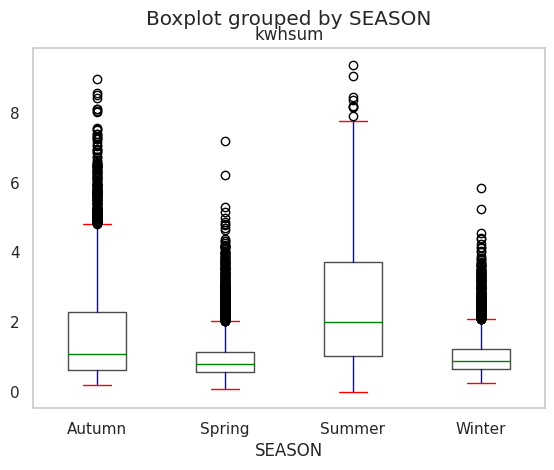

In [32]:
sns.set_style("whitegrid")
PROPS = {
    'medianprops':{'color':'green'},
    'whiskerprops':{'color':'blue'},
    'capprops':{'color':'red'}
}

df.boxplot(by ='SEASON', column =['kwhsum'], grid = False, **PROPS)

In [33]:
df.columns

Index(['year', 'month', 'day', 'hour', 'kwhsum', 'time', 'T_HR_AVG', 'SOLARAD',
       'P_CALC', 'SEASON', 'SUNLIGHT', 'TIME_OF_DAY'],
      dtype='object')

##Look at the plots

/home/chris/ml/home_energy/.venv/lib/python3.8/site-packages/statsmodels/graphics/factorplots.py:144: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


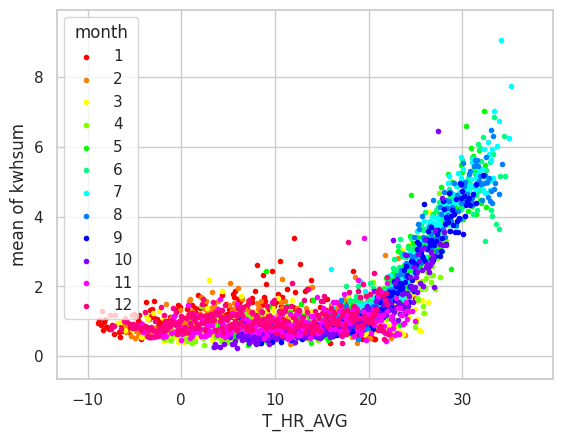

In [34]:
from statsmodels.graphics.factorplots import interaction_plot

fig = interaction_plot(
    x = df['T_HR_AVG'],
    trace = df['month'],
    response = df['kwhsum'],
    plottype = 's',
)
plt.show()


### Do some categorization

/home/chris/ml/home_energy/.venv/lib/python3.8/site-packages/statsmodels/graphics/factorplots.py:144: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


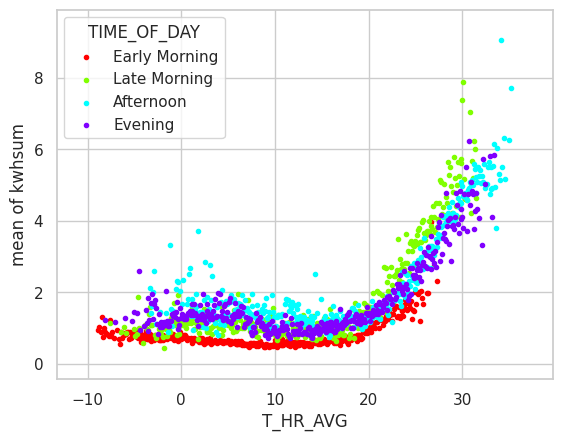

In [35]:
fig = interaction_plot(
    x = df['T_HR_AVG'],
    trace = df['TIME_OF_DAY'],
    response = df['kwhsum'],
    plottype = 'scatter',
)
plt.show()

/home/chris/ml/home_energy/.venv/lib/python3.8/site-packages/statsmodels/graphics/factorplots.py:144: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


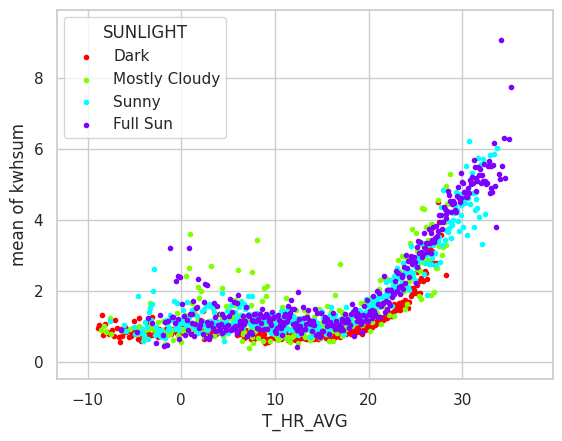

In [36]:
fig = interaction_plot(
    x = df['T_HR_AVG'],
    trace = df['SUNLIGHT'],
    response = df['kwhsum'],
    plottype = 'scatter',
)
plt.show()

/home/chris/ml/home_energy/.venv/lib/python3.8/site-packages/statsmodels/graphics/factorplots.py:144: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


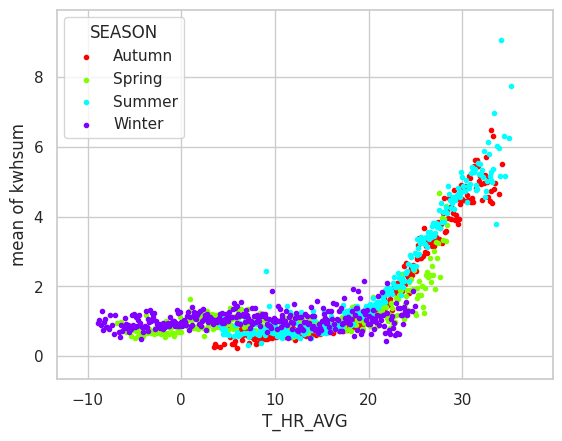

In [37]:
fig = interaction_plot(
    x = df['T_HR_AVG'],
    trace = df['SEASON'],
    response = df['kwhsum'],
    plottype = 'scatter',
)
plt.show()

(17591, 12)

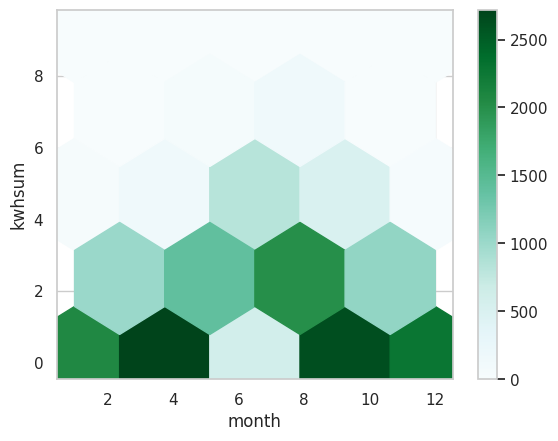

In [38]:
df.plot.hexbin(x="month", y = "kwhsum",  reduce_C_function=np.sum, gridsize=4) #type: ignore
#df.reset_index().plot.scatter(x = 'time', y = "T_HR_AVG", s=df["kwhsum"] * 200)
df.shape


In [39]:
columns = df.columns
print(columns)
df.head()


Index(['year', 'month', 'day', 'hour', 'kwhsum', 'time', 'T_HR_AVG', 'SOLARAD',
       'P_CALC', 'SEASON', 'SUNLIGHT', 'TIME_OF_DAY'],
      dtype='object')


,year,month,day,hour,kwhsum,time,T_HR_AVG,SOLARAD,P_CALC,SEASON,SUNLIGHT,TIME_OF_DAY
time,,,,,,,,,,,,
2020-09-15 00:00:00-04:00,2020,9,15,0,0.85,2020-09-15 00:00:00-04:00,18.9,0.0,0.0,Autumn,Dark,Early Morning
2020-09-15 01:00:00-04:00,2020,9,15,1,0.81,2020-09-15 01:00:00-04:00,18.3,0.0,0.0,Autumn,Dark,Early Morning
2020-09-15 02:00:00-04:00,2020,9,15,2,0.65,2020-09-15 02:00:00-04:00,17.3,0.0,0.0,Autumn,Dark,Early Morning
2020-09-15 03:00:00-04:00,2020,9,15,3,0.57,2020-09-15 03:00:00-04:00,17.1,0.0,0.0,Autumn,Dark,Early Morning
2020-09-15 04:00:00-04:00,2020,9,15,4,0.72,2020-09-15 04:00:00-04:00,16.7,0.0,0.0,Autumn,Dark,Early Morning


### Export to Excel and CSV

In [40]:
df_no_tz = df.filter(['year', 'month', 'day', 'hour', 'kwhsum',
       'T_HR_AVG', 'SOLARAD', 'P_CALC', 'SEASON', 'SUNLIGHT', 'TIME_OF_DAY'], axis=1)
df_no_tz = df_no_tz.tz_localize(None) # make naive date because to_excel doesn't handle TZ aware dates
df_no_tz.to_excel("energyUsage.xlsx")
del(df_no_tz)

In [41]:
df.to_csv('home-energy-dataframe.csv')